In [1]:
import glob
import torch
import numpy as np
import cv2
import json

from pathlib import Path
from PIL import Image
from torch.nn.functional import cosine_similarity
from transformers import SamModel, SamImageProcessor

c:\Users\Andrew Deur\miniconda3\envs\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def load_image(path: Path) -> Image.Image:
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def compute_sam_embedding(image_path: Path, flatten=True, normalize=True) -> torch.Tensor:
    image = load_image(image_path)
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.vision_encoder(pixel_values=inputs["pixel_values"])
        embedding = output.last_hidden_state.squeeze(0)  # shape: [256, H/16, W/16]

        if flatten:
            embedding = embedding.flatten(start_dim=1).mean(dim=1)  # mean pool to [256]

        if normalize:
            embedding = torch.nn.functional.normalize(embedding, dim=0)

    return embedding.cpu()


In [3]:
def compare_embeddings(emb1: torch.Tensor, emb2: torch.Tensor) -> float:
    return cosine_similarity(emb1, emb2, dim=0).item()

In [4]:
model_name = "facebook/sam-vit-huge"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained(model_name).to(device)
processor = SamImageProcessor.from_pretrained(model_name)
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

In [5]:
image_dir = Path(r"C:\Users\Andrew Deur\Documents\NYU\DS-GA 1006 Capstone\Data\SimCLR")

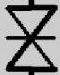

In [6]:
img = image_dir / 'class_1.png'
Image.open(img)

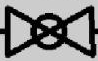

In [7]:
img2 = image_dir / 'class_2.png'
Image.open(img2)

In [8]:
emb1 = compute_sam_embedding(img)
emb2 = compute_sam_embedding(img2)

similarity = compare_embeddings(emb1, emb2)
print(f"Cosine similarity between {img.name} and {img2.name}: {similarity:.4f}")

Cosine similarity between class_1.png and class_2.png: 0.9252


In [9]:
emb1 = compute_sam_embedding(img)
emb2 = compute_sam_embedding(img)

similarity = compare_embeddings(emb1, emb2)
print(f"Cosine similarity between {img.name} and {img2.name}: {similarity:.4f}")

Cosine similarity between class_1.png and class_2.png: 1.0000


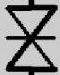

In [10]:
img = image_dir / 'class_1.png'
img2 = image_dir / 'class_19_a.png'

Image.open(img)

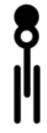

In [11]:
Image.open(img2)

In [12]:
emb1 = compute_sam_embedding(img)
emb2 = compute_sam_embedding(img2)

similarity = compare_embeddings(emb1, emb2)
print(f"Cosine similarity between {img.name} and {img2.name}: {similarity:.4f}")

Cosine similarity between class_1.png and class_19_a.png: 0.7677


## Ground Truth Embeddings

In [2]:
root = Path().resolve().parents[1]
model_folder = 'train8'

In [69]:
# GT Class Images
gt_imgs_path = root / 'Data' / 'test' / 'fw_system' / 'labels' / '*.png'
gt_imgs = glob.glob(str(gt_imgs_path))

# Detection Images
imgs_path = root / 'Data' / 'test' / 'fw_system' / 'predictions' / model_folder / '*.png'
prediction_imgs = glob.glob(str(imgs_path))

# Class ID to Labels
class_labels = root / 'Data' / 'test' / 'fw_system' / 'labels' / 'notes.json'
with open(class_labels) as json_data:
    d = json.load(json_data)

# Translate Class ID to labels
gt_indices = [0, 1, 3, 6, 7, 9, 11, 12, 15, 16, 18, 21, 23, 24, 25, 27, 28, 30, 31, 32, 39]
labels = [d['categories'][i] for i in gt_indices]

In [70]:
from PIDObjectLookupTable import ObjectLookupTableSAM

pid_lookup_table = ObjectLookupTableSAM(labels, gt_imgs)
max_sim, match_class = pid_lookup_table.classify(prediction_imgs)

In [71]:
import re

regex = re.compile("_([0-9]+)\.png")
paths = pid_lookup_table.gt_image_paths
gt_class_labels = [regex.search(x).group(1) for x in paths]

In [72]:
match_class_converted = [gt_class_labels[x] for x in match_class]

In [73]:
id_to_name = {item['id']: item['name'] for item in pid_lookup_table.class_labels}
class_name = [id_to_name[int(x)] for x in match_class_converted]

In [75]:
from collections import Counter

counts = Counter(class_name)

In [76]:
for item, count in counts.items():
    print(f"{item}: {count}")

Control Measurement Point: 21
Inline Flow Meter: 37
Centrifugal Pump: 1
Reducer: 4
Swinging Disk Check Valve: 1
Flow Arrow: 2
Flange: 5
Inline Indicator: 2
Gate Valve N.O. #1: 2
Gate Valve N.O. #2: 13
PLC: 1
Coupling: 1
Globe Valve N.O.: 1
Needle Valve: 4
Gate Valve Pneumatic: 1
Hose Bib: 4
Pressure Vessel: 1
Ball Valve N.C.: 3
Motor: 1
